# Introduction
This colab worksheet provides a starting point for the computer vision assignment.

# Imports and GPU

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torch.nn as nn
import torch.optim as optim
import cv2
from sklearn.cluster import KMeans

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


# Data Loading and Checksums
Checking the data downloaded correctly. If any of these assertions fail, redownload the data.

In [20]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

# Train images
# !wget "https://qmul.box.com/shared/static/7twlgb1dlkxi94qw9d31shdkll92hxnr.npz" -O training_images.npz

# The test images (without points)
# !wget "https://qmul.box.com/shared/static/dao3ei4all8ezpixi50bm5siam2z1yq4.npz" -O test_images.npz

# The example images are here
# !wget "https://qmul.box.com/shared/static/l6lvtqa50jgymwjm57aorao3oitm1e0h.npz" -O examples.npz

# Checksums
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', '337cf2d2959a9304651e8774955f6587ea503c3c')
confirm_checksum('test_images.npz', '277f782049c2e541e468ca96b4c9cd646fe8508d')
confirm_checksum('examples.npz', 'f215b37ddfd0ca04a0a389a893500d5fce60ead4')

# Loading Data and Preprocessing

In [21]:
# Train data
# Loading the data using np.load
train_data = np.load('training_images.npz', allow_pickle=True)
# Extracting the images
train_images = train_data['images']
# Extracting and the data points
train_pts = train_data['points']
# Printing shape of images and pts
print("Train images shape: ", train_images.shape, "\nTrain pts shape: ", train_pts.shape)
# print("Train images type: ", type(train_images), "\nTrain pts type: ", type(train_pts))

# Test data
# Loading the data using np.load
test_data = np.load('test_images.npz', allow_pickle=True)
# Extracting the images
test_images = test_data['images']
# Printing shape of images
print("Test images shape: ", test_images.shape)

# Example data
# Loading the data using np.load
example_data = np.load('examples.npz', allow_pickle=True)
# Extracting the images
example_images = example_data['images']
# Printing shape of images
print("Example images shape: ", example_images.shape)

# Data loaders
# Composing general transformations data that will be input to the model
transformation = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Change dimensions from HxWxC to CxHxW
    torchvision.transforms.Resize((32, 32)), # Resize to 32x32
    torchvision.transforms.ToTensor() # Convert to pytorch tensor
])

# Storing training points in a tensor to include as labels in a TensorDataset instance
pts_tensor = torch.tensor(train_pts, dtype=torch.float32)
# Applying transformations to the train images and storing them with train points in a new TensorDataset instance
train_dataset = TensorDataset(torch.stack([transformation(image) for image in train_images]), pts_tensor)
# Creating a DataLoader instance for the training data (images and points) in the TensorDataset train_dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Train images shape:  (2811, 256, 256, 3) 
Train pts shape:  (2811, 52, 2)
Test images shape:  (554, 256, 256, 3)
Example images shape:  (6, 256, 256, 3)


# Data Visualisation
Here's an example of how to display the images and their points

Training images
(2811, 256, 256, 3) (2811, 52, 2)


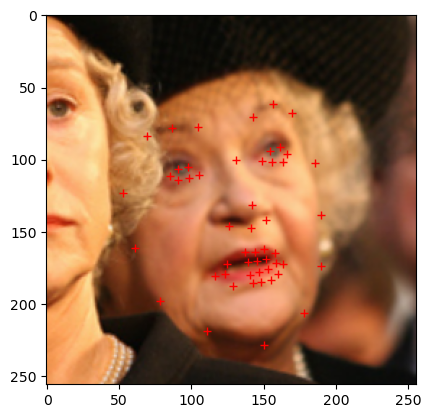

In [22]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

print("Training images")
for i in range(1):
  idx = np.random.randint(0, train_images.shape[0])
  print(train_images.shape, train_pts.shape)
  visualise_pts(train_images[idx, ...], train_pts[idx, ...])

# Model Evaluation

In [23]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  # import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


def evaluate_model(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    for X, y in data_iter: # For every batch
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Predict labels
        m = metric(logits.cpu().numpy(), y.cpu().numpy()) # Compute metric
        c += m.mean() # Take batch average

    return float(c / len(data_iter)) # Return average of all batches

# Model and Training

In [24]:
# Neural network architecture: Convolutional neural network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 104) # 104 points (52 pairs of x and y coordintes)

    def forward(self, x):
        # for debugging
        # print("Before:", x.shape)
        # print("After:", x.shape)

        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.size(0), 52, 2)
        return x

# Initializing a model and specifying hyperparameters
model = Model().to(device) # NN instance
criterion = nn.MSELoss() # Loss criterion
lr = 0.001 # Learning rate
# lr = 0.0005 # Learning rate
optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer
# num_epochs = 300 # Number of training epocs
num_epochs = 500 # Number of training epocs

losses = [] # To store losses for each epoch
train_distance = [] # To store euclidean distance for each epoch

# Training loop
for epoch in range(num_epochs): # For every number of epochs
    model.train() # Train mode for correct behaviour of batch normalization
    running_loss = 0.0 # Epoch loss will be stored here
    for batch in train_loader: # For every batch
        images = batch[0].to(device) # Predictor
        pts = batch[1].to(device)    # Label
        optimizer.zero_grad() # Set previous gradients to zero
        outputs = model(images) # Calculate face alignment points for all images in the batch
        loss = criterion(outputs, pts) # Difference between predicted labels and training labels
        loss.backward() # Compute gradient of loss wrt model parameters
        optimizer.step() # Update model parameters
        
        running_loss += loss.item() # Add loss of this batch to total epoch loss
    losses.append(running_loss/len(train_loader)) # Store the epoch loss for current epoch
    distance = 0
    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval() # Eval mode for correct behaviour of batch normalization
        distance = evaluate_model(model, train_loader, euclid_dist)
        train_distance.append(distance)    
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Distance: {distance:.4f}')

Epoch [1/500], Loss: 2296.6344, Distance: 16.5284
Epoch [2/500], Loss: 159.0464, Distance: 13.7161
Epoch [3/500], Loss: 135.3717, Distance: 13.5482
Epoch [4/500], Loss: 134.9074, Distance: 13.8245
Epoch [5/500], Loss: 132.6517, Distance: 12.9759
Epoch [6/500], Loss: 131.9359, Distance: 13.2696
Epoch [7/500], Loss: 132.2265, Distance: 12.9126
Epoch [8/500], Loss: 131.1576, Distance: 13.6818
Epoch [9/500], Loss: 134.4464, Distance: 13.0887
Epoch [10/500], Loss: 140.7729, Distance: 14.9178
Epoch [11/500], Loss: 143.2163, Distance: 12.9620
Epoch [12/500], Loss: 129.9692, Distance: 13.7126
Epoch [13/500], Loss: 137.6918, Distance: 14.0741
Epoch [14/500], Loss: 131.9827, Distance: 14.1010
Epoch [15/500], Loss: 137.8081, Distance: 13.0062
Epoch [16/500], Loss: 133.2061, Distance: 13.5679
Epoch [17/500], Loss: 137.2168, Distance: 13.0910
Epoch [18/500], Loss: 132.8639, Distance: 12.9214
Epoch [19/500], Loss: 134.8717, Distance: 12.8417
Epoch [20/500], Loss: 132.6759, Distance: 13.3430
Epoch [2

# Plots

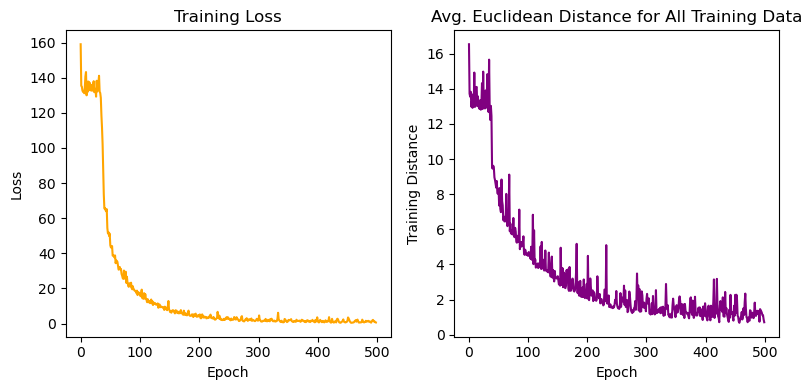

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

ax1.plot(losses[1:], label = 'Loss', color = 'orange') # Plots the loss for each epoch
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title("Training Loss")

ax2.plot(train_distance, label='Training distance', color = 'purple') # Plot average euclidean distance for each epoch
ax2.set_ylabel('Training Distance')
ax2.set_xlabel('Epoch')
ax2.set_title("Avg. Euclidean Distance for All Training Data")

plt.tight_layout()
plt.show()

# Testing

In [26]:
# Function to align face using a model
def align_face(image, model):
    image_tensor = transformation(image).unsqueeze(0).to(device) # Applying transformations and adding batch dimension
    with torch.no_grad():
        pts = model(image_tensor).cpu().numpy().squeeze(0) # Predicting points, converting to np array, and removing batch dimension
    return pts

# Function to visualise two sets of points on an image
def compare_pts(img, pts, pred):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r') # labeled points
  plt.plot(pred[:, 0], pred[:, 1], '+g') # predicted points
  plt.show()

## Comparing Predicted and Label Points

Train Image 1286


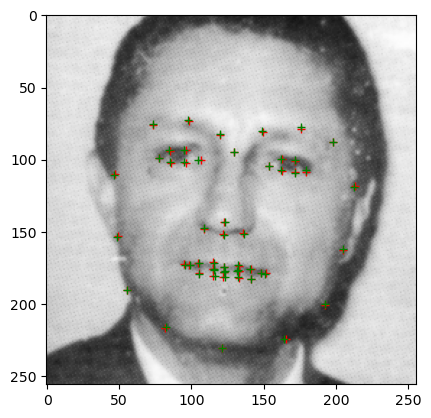

In [27]:
# Testing model on train images and visualizing
for i in range(1):
  idx = np.random.randint(0, train_images.shape[0])
  print("Train Image", idx)
  compare_pts(train_images[idx, ...], train_pts[idx, ...], align_face(train_images[idx, ...], model))

## Testing using Test Images

Test Image 126


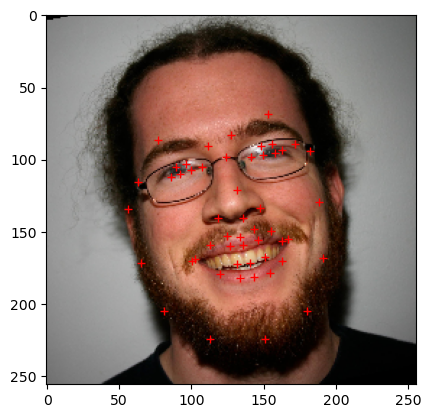

In [28]:
# Testing model on test images and visualizing
for i in range(1):
  idx = np.random.randint(0, test_images.shape[0])
  print("Test Image", idx)
  visualise_pts(test_images[idx, ...], align_face(test_images[idx, ...], model))

## Testing using Example Images

Example Image 0


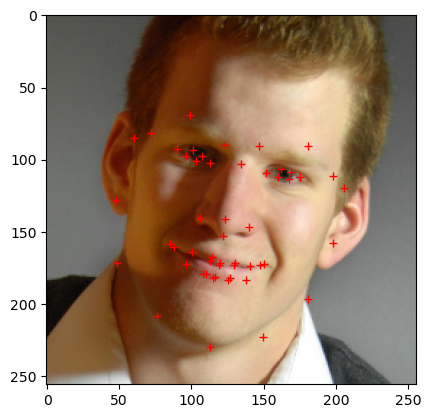

Example Image 1


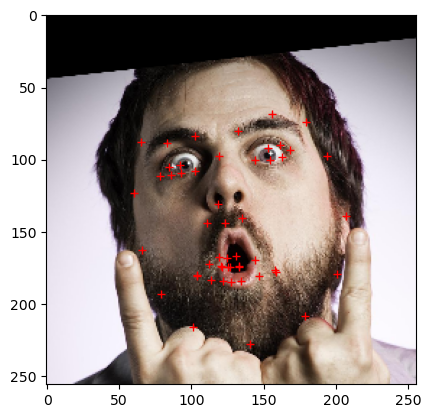

Example Image 2


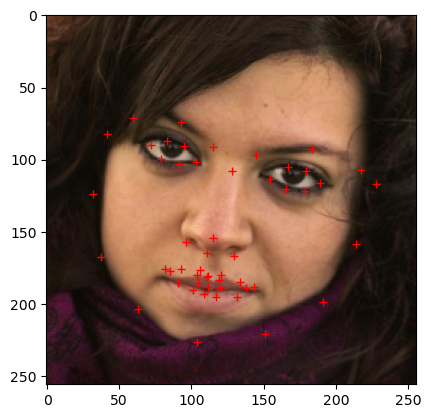

Example Image 3


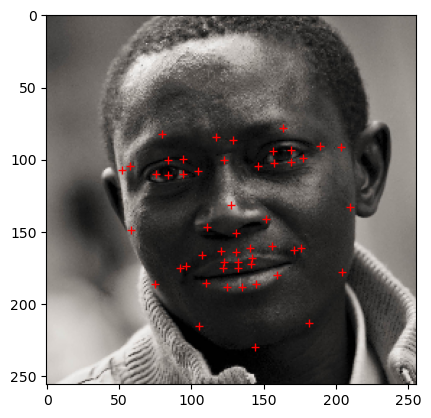

Example Image 4


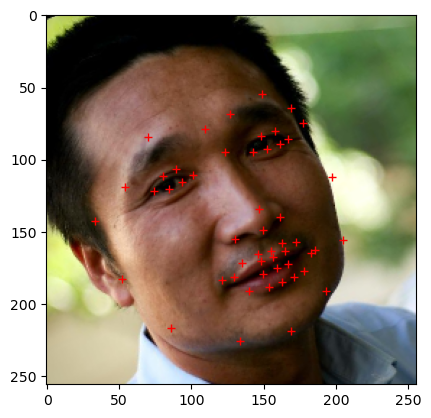

Example Image 5


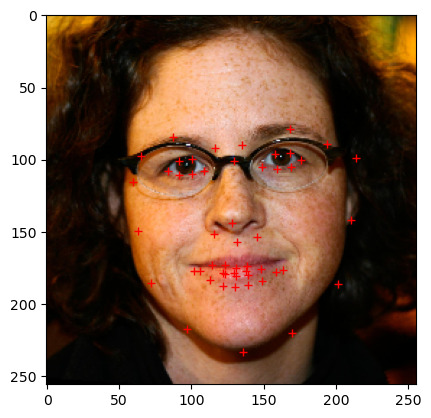

In [29]:
# Testing model on example images and visualizing
for idx in range(example_images.shape[0]):
  print("Example Image", idx)
  visualise_pts(example_images[idx, ...], align_face(example_images[idx, ...], model))

# Calculating Prediction Error and exporting results

In [30]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [31]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==52*2, 'wrong number of points provided. There should be 52 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [32]:
# Calculating points for all test data and saving to csv
points = []
for idx in range(test_images.shape[0]):
  predicted_pts = align_face(test_images[idx, ...], model)
  points.append(predicted_pts)
# print(np.array(points).shape)
# print(np.array(points))
# save_as_csv(np.array(points))
  

# Face Segmentation

## Function for Face Segmentation

In [33]:
def segment_face(image, landmarks): # A function to segment face using landmarks
    # Segmentation using landmarks
    mask = np.zeros(image.shape[:2], dtype=np.uint8) # Create a mask for the entire face
    landmarks = np.array(landmarks, dtype=np.int32) # Convert landmarks to int32 dtype because fillConvexPoly accepts int32 points
    hull = cv2.convexHull(landmarks) # Create a convex hull around landmarks using cv2.convexHull
    cv2.fillConvexPoly(mask, hull, 255) # Fill the empty mask array with convex polygon of the shape specified by the hull (created using landmarks)
    landmarks_only_segmented_face = cv2.bitwise_and(image, image, mask=mask) # The bitwise_and is only being used here for its optional mask argument to apply the mask
    
    # Segmentation using skin colour
    face_hsv = cv2.cvtColor(landmarks_only_segmented_face, cv2.COLOR_BGR2HSV) # Convert face region to HSV for better skin colour detection
    face_pixels = face_hsv[np.where(mask == 255)] # Extract pixels from inside the landmark mask
    lower_skin = np.min(face_pixels, axis=0) # Compute the minimum value for colour in the face region
    upper_skin = np.max(face_pixels, axis=0) # Compute the max value for colour in the face region
    lower_skin = np.clip(lower_skin, [0, 30, 60], [180, 255, 255]) # Check that the min value does not go below minimum value in HSV colour space
    upper_skin = np.clip(upper_skin, [0, 30, 60], [180, 255, 255]) # Check that the max value does not go below maximum value in HSV colour space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # Convert image to hsv finding pixels in skin colour range
    skin_mask = cv2.inRange(image_hsv, lower_skin, upper_skin) # Find pixels in skin colour range
    skin_mask_segmented_face = cv2.bitwise_and(image, image, mask=skin_mask) # The bitwise_and is only being used here for its optional mask argument to apply the mask
    
    # Segmentation using Both
    combined_mask = cv2.bitwise_and(mask, skin_mask) # Create the combined mask
    combined_mask_segmented_face = cv2.bitwise_and(image, image, mask=combined_mask) # The bitwise_and is only being used here for its optional mask argument to apply the mask
    
    return mask, landmarks_only_segmented_face, skin_mask, skin_mask_segmented_face, combined_mask, combined_mask_segmented_face

## Segmentation on Train Images and Labled Landmarks

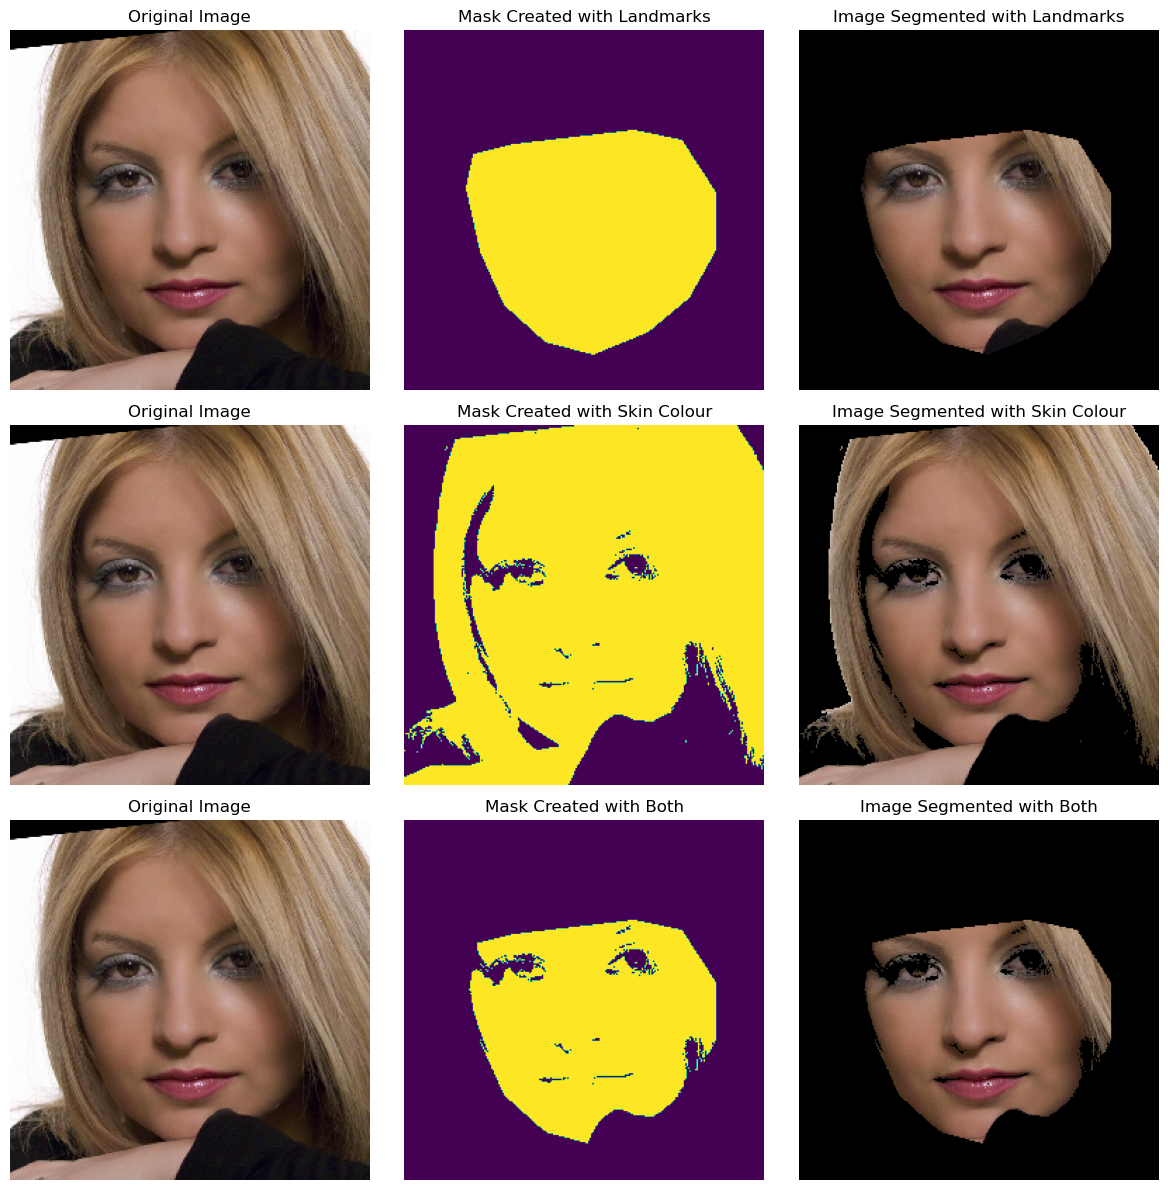

In [34]:
idx = np.random.randint(0, train_images.shape[0]) # Generate a random index for the train dataset
image = train_images[idx, :] # The image
landmarks = train_pts[idx, :] # Labeled points from train dataset
mask, landmarks_only_segmented_face, skin_mask, skin_mask_segmented_face, combined_mask, combined_mask_segmented_face = segment_face(image, landmarks) # Use the function

# Printing the original image, all masks, and segmented faces using respective masks
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(mask)
axs[0, 1].set_title('Mask Created with Landmarks')
axs[0, 1].axis('off')

axs[0, 2].imshow(landmarks_only_segmented_face)
axs[0, 2].set_title('Image Segmented with Landmarks')
axs[0, 2].axis('off')

axs[1, 0].imshow(image)
axs[1, 0].set_title('Original Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(skin_mask)
axs[1, 1].set_title('Mask Created with Skin Colour')
axs[1, 1].axis('off')

axs[1, 2].imshow(skin_mask_segmented_face)
axs[1, 2].set_title('Image Segmented with Skin Colour')
axs[1, 2].axis('off')

axs[2, 0].imshow(image)
axs[2, 0].set_title('Original Image')
axs[2, 0].axis('off')

axs[2, 1].imshow(combined_mask)
axs[2, 1].set_title('Mask Created with Both')
axs[2, 1].axis('off')

axs[2, 2].imshow(combined_mask_segmented_face)
axs[2, 2].set_title('Image Segmented with Both')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()

## Segmentation on Test Dataset and Predicted Landmarks

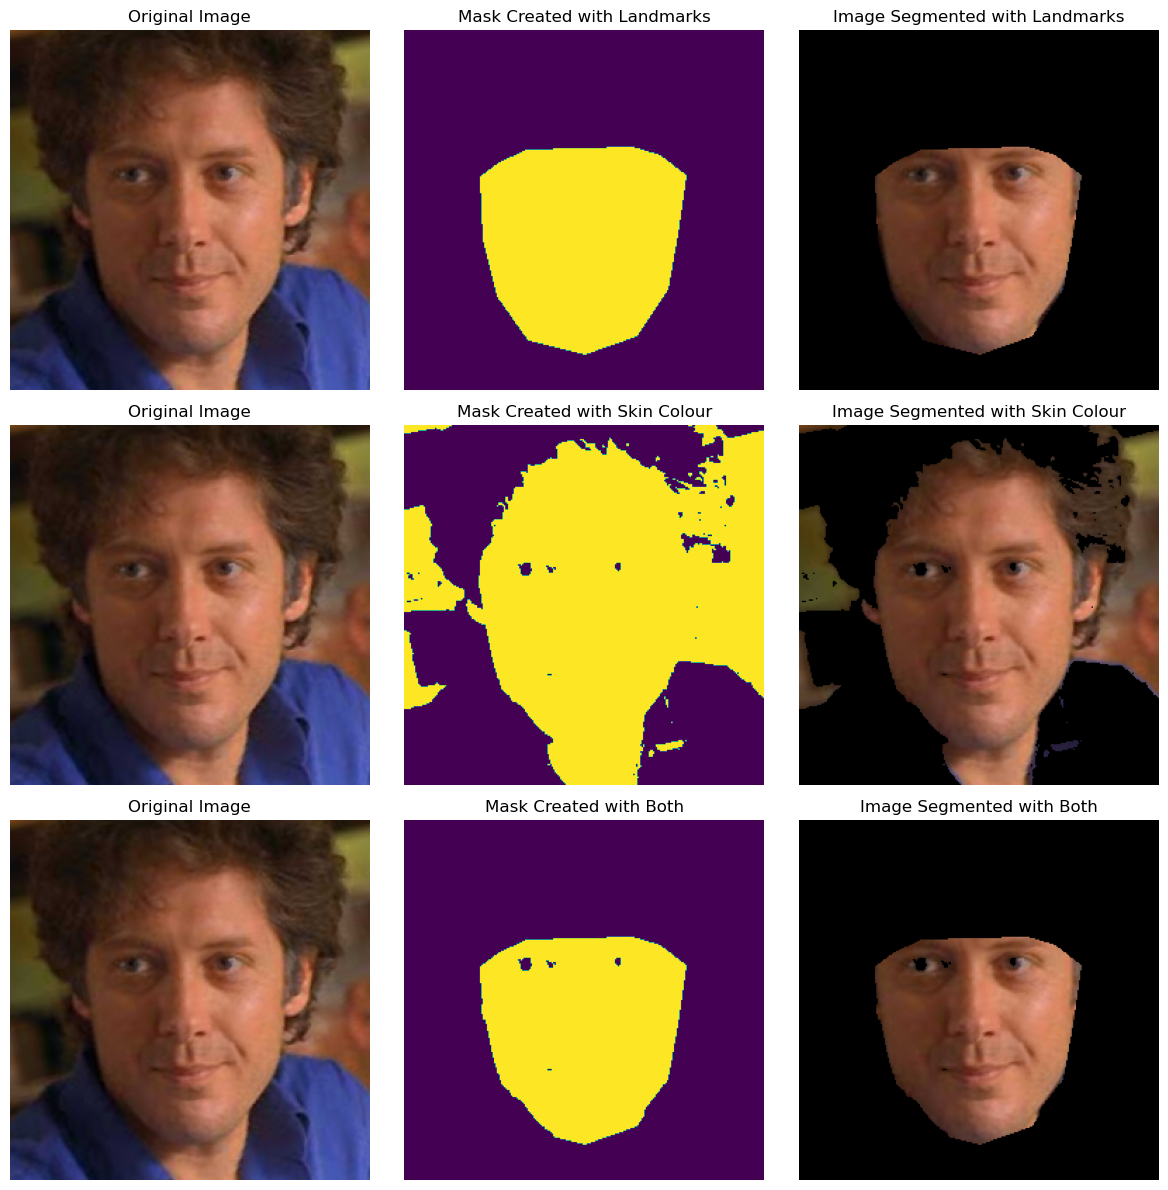

In [35]:
idx = np.random.randint(0, test_images.shape[0]) # Generate a random index for the test dataset
image = test_images[idx, :] # The image
landmarks = align_face(test_images[idx, :], model) # Predict points using the model
mask, landmarks_only_segmented_face, skin_mask, skin_mask_segmented_face, combined_mask, combined_mask_segmented_face = segment_face(image, landmarks) # Use the function

# Printing the original image, all masks, and segmented faces using respective masks
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(mask)
axs[0, 1].set_title('Mask Created with Landmarks')
axs[0, 1].axis('off')

axs[0, 2].imshow(landmarks_only_segmented_face)
axs[0, 2].set_title('Image Segmented with Landmarks')
axs[0, 2].axis('off')

axs[1, 0].imshow(image)
axs[1, 0].set_title('Original Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(skin_mask)
axs[1, 1].set_title('Mask Created with Skin Colour')
axs[1, 1].axis('off')

axs[1, 2].imshow(skin_mask_segmented_face)
axs[1, 2].set_title('Image Segmented with Skin Colour')
axs[1, 2].axis('off')

axs[2, 0].imshow(image)
axs[2, 0].set_title('Original Image')
axs[2, 0].axis('off')

axs[2, 1].imshow(combined_mask)
axs[2, 1].set_title('Mask Created with Both')
axs[2, 1].axis('off')

axs[2, 2].imshow(combined_mask_segmented_face)
axs[2, 2].set_title('Image Segmented with Both')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()